# Laplace-Beltrami Operator

This notebook computes the ```laplacian.txt``` file for a given a quad-only template mesh. The Laplacian is used to reduce unrealistic shape deformations during training.

We compute the discrete Laplacian following http://ddg.math.uni-goettingen.de/pub/Polygonal_Laplace.pdf. In (5) a symmetric, positive defnite matrix $M_f \in \mathbb{R}^{4 \times 4}$ is introduced for each face with $1 \le f \le F$ where $F$ is the number of faces. The code factors each $M_f$ with a cholesky factorization $M_f = A_fA_f^T$ leading to the factors $A_f$ and $A_f^T$. 

The matrices $A_f^T$ are converted to vectors (concatenating the matrix rows) and the resulting vectors are concatenated leading to a vector $(\operatorname{vec}(A_1^T),\operatorname{vec}(A_2^T),\cdots,\operatorname{vec}(A_F^T)) \in \mathbb{R}^{16F}$. This vector is stored in ```laplacian.txt```.

In [1]:
import numpy as np
from scipy.linalg import block_diag
from scipy.linalg import orth
import scipy as sp
import numpy.linalg as la
import scipy.linalg as spla
from matplotlib import cm
import matplotlib.pylab as plt
import matplotlib as mpl
import meshplot as mp
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets

In [2]:
def read_wavefront(path):
    with open( path, 'r') as fp:
        vertices = []
        faces = []
        normals = []
        for line in fp:
            if line.startswith('#'):
                continue
            parts = line.split()
            if len(parts) == 0:
                continue
            if parts[0] == 'v':
                vertices.append( np.array([float(x) for x in parts[1:] ]) )
            elif parts[0] == 'vn':
                normals.append( np.array([float(x) for x in parts[1:] ]) )
            elif parts[0] == 'f':
                stripped = [int(x.split('//')[0]) - 1 for x in parts[1:] ]
                faces.append(np.array(stripped,dtype=np.int))
            elif parts[0] == 'g':
                continue
            elif parts[0] == 's':
                continue
            else:
                return None
        f = np.vstack(faces)

        return np.vstack(vertices), f

In [3]:
def quadLaplace(v,f):
    outtype = np.float64
    vertexFaceAdj = {}
    for fi, face in enumerate(f):
        for vert in face:
            if not vert in vertexFaceAdj:
                vertexFaceAdj[vert] = []
            vertexFaceAdj[vert].append(fi)
    E = np.zeros([f.shape[0],4,3],dtype=outtype)
    Ebar = np.zeros([f.shape[0],4,3],dtype=outtype)
    B = np.zeros([f.shape[0],4,3],dtype=outtype)
    M1 = []
    M1_flat = np.zeros([4*f.shape[0],4*f.shape[0]],dtype=outtype)
    M0 = np.zeros([v.shape[0]],dtype=outtype)
    faceArea = np.zeros([f.shape[0]],dtype=outtype)
    d = np.zeros([4*f.shape[0],v.shape[0]],dtype=outtype)
    for fi, face in enumerate(f):
        for i in range(4):
            j = (i+1) % 4
            E[fi,i] = v[face[j]] - v[face[i]]
            B[fi,i] = .5 * (v[face[j]] + v[face[i]])
        A = E[fi].T.dot(B[fi])
        fA = np.linalg.norm(A)/np.sqrt(2)
        
        faceArea[fi] = fA
        
        Mcurl = (1.0/fA)* B[fi].dot(B[fi].T)
        nv = np.array([-A[1,2],A[0,2],-A[0,1]])
        n = nv / np.linalg.norm(nv)
        xbar = np.zeros([4,3],dtype=outtype)
        for i in range(4):
            xbar[i] = v[face[i]] - v[face[i]].dot(n.T)*n
        for i in range(4):
            j = (i+1) % 4
            Ebar[fi,i] = xbar[j] - xbar[i]
        _, sigma, VT = la.svd(Ebar[fi].T)
        ns = (sigma>=1e-13).sum()
        C = VT[ns:].conj().T
        U = 2*np.eye(C.shape[1])
        mf = Mcurl + C.dot(U).dot(C.T)
        M1.append(mf)
        for i in range(4):
            j = (i+1) % 4
            d[4*fi+i,face[i]] = -1
            d[4*fi+i,face[j]] = 1
        for i in range(4):
            vId = face[i]
            k = len(vertexFaceAdj[vId])
            M0[vId] = M0[vId] + fA/k
    M1_factored = []
    for i in range(f.shape[0]):
        chol = np.linalg.cholesky(M1[i]).T
        M1_factored.append(chol)
    M1_flat = sp.linalg.block_diag(*M1)
    D = np.reciprocal(M0, where= M0 != 0)
    L_weak = d.T.dot(M1_flat).dot(d)
    L_strong = np.diag(D).dot(L_weak)
    L_graph = d.T.dot(d)
    
    Dsqrt = np.sqrt(D)  
    M1sqrt = sp.sparse.block_diag(M1_factored,format="bsr")
    return L_weak, L_strong, L_graph, M1sqrt.dot(d), M1_factored

v,f = read_wavefront('shape.obj')

lmbda = 10.5

L_weak, L_strong, L_graph, L_sqrt, M1_sqrt  = quadLaplace(v,f)
with open("laplacian.txt",'w') as File:
    for chol in M1_sqrt:
        for elem in range(16):
            File.write(str(chol[elem//4, elem%4])+"\n")

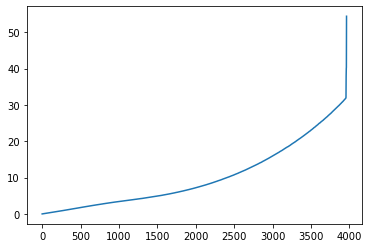

In [4]:
Le, Lv = np.linalg.eigh(L_weak)
idx = Le.argsort()
Le = Le[idx]
Lv = Lv[:,idx]
plt.plot(Le)

Meshplot is buggy and the normalization settings do not work. We add two fake vertices and color values to control the min/max values

In [5]:
norm = mpl.colors.Normalize(vmin=-1.,vmax=1.)
vdummpy = np.vstack([v,[0,0,0],[0,0,0]])
p = mp.plot(vdummpy,f,c=np.zeros(vdummpy.shape[0],dtype=np.float32),shading={
    "colormap": plt.cm.get_cmap("viridis"),
})
def eigenvector_callback(x):
    vis = Lv[:,x].copy()  
    boundary = np.abs(Lv[:,:51]).max()
    print(boundary)
    vis = np.concatenate([vis,[-boundary,boundary]])
    #vis = (vis-vis.mean()) / (2*vis.std()) #+ .5
    p.update_object(colors=vis)
interact(eigenvector_callback, x=widgets.IntSlider(min=0, max=50, step=1, value=0));

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, -0.0…

interactive(children=(IntSlider(value=0, description='x', max=50), Output()), _dom_classes=('widget-interact',…